In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Places2

In [ ]:
import shutil 
shutil.unpack_archive("drive/MyDrive/Places2.zip", "Places2/")

images-size: torch.Size([128, 3, 256, 256])
out-size: torch.Size([3, 4130, 2066])


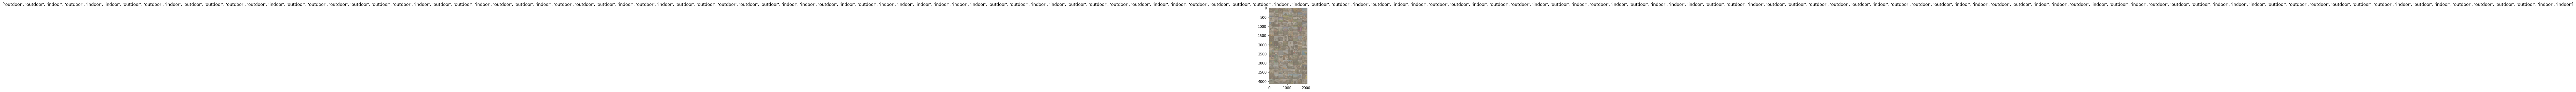

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/content/Places2/Places2/train', transform=transforms)
test_dataset = datasets.ImageFolder(root='/content/Places2/Places2/test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [ ]:
!nvidia-smi

Tue Jul  6 05:31:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import torchvision.models as models

In [ ]:

net = models.resnet18(pretrained=True)
net = net.cuda() 
net

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() 

In [ ]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/30], Step [0/46], Loss: 4.9936
Epoch [1/30], Step [20/46], Loss: 4.9609
Epoch [1/30], Step [40/46], Loss: 4.8110

train-loss: 4.9533, train-acc: 0.0860
validation loss: 4.8748, validation acc: 0.4814

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/46], Loss: 4.8455
Epoch [2/30], Step [20/46], Loss: 4.8482
Epoch [2/30], Step [40/46], Loss: 4.7753

train-loss: 4.8643, train-acc: 0.1892
validation loss: 4.7685, validation acc: 1.1004

Improvement-Detected, save-model
Epoch 3

Epoch [3/30], Step [0/46], Loss: 4.6227
Epoch [3/30], Step [20/46], Loss: 4.6361
Epoch [3/30], Step [40/46], Loss: 4.4219

train-loss: 4.7640, train-acc: 1.2386
validation loss: 4.6569, validation acc: 2.9574

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/46], Loss: 4.4586
Epoch [4/30], Step [20/46], Loss: 4.3510
Epoch [4/30], Step [40/46], Loss: 4.2262

train-loss: 4.6545, train-acc: 6.5371
validation loss: 4.5341, validation acc: 13.8239

Improvement-Detected, save-model


In [ ]:
torch.save(net, '/content/Places2/modelResnet18.pth')

In [ ]:
torch.save(net.state_dict(), "/content/Places2/cifar10_model")

In [ ]:
clf = CIFAR10_clf()
clf.load("cifar10_model")

# Make predictions
predicted = clf.predict(images)

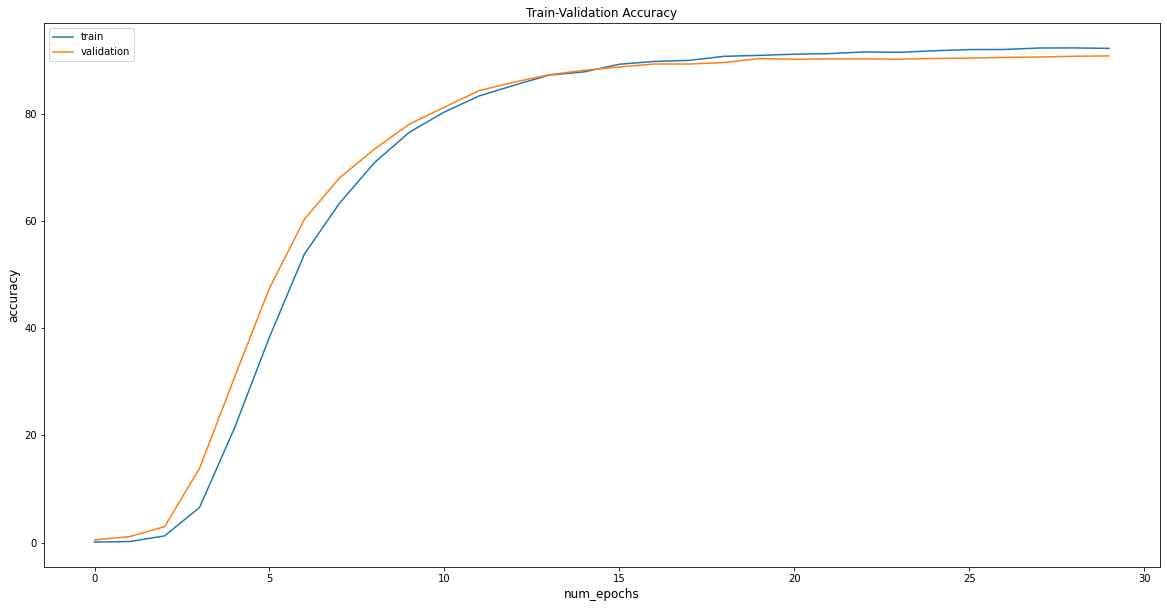

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=torch.load('/content/Places2/modelResnet18.pth')
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

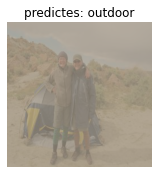

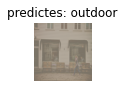

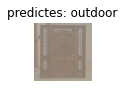

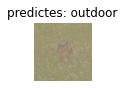

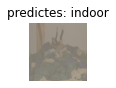

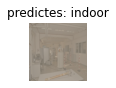

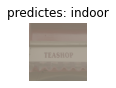

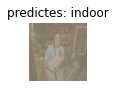

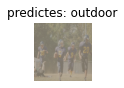

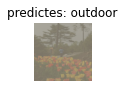

In [ ]:

use_cuda = torch.cuda.is_available()
def visualize_model(net, num_images=10):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()